In [83]:
import warnings
warnings.filterwarnings('ignore')

In [84]:
import sqlite3
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller

In [85]:
database_filepath = "./accident_data_v1.0.0_2023.db"

In [86]:
query = """
    SELECT date, accident_index, police_force
    FROM accident
    WHERE police_force IN (11, 12, 13)
    AND accident_year BETWEEN 2017 AND 2020;
"""

In [87]:
df = None
with sqlite3.connect(database_filepath) as conn:
    df = pd.read_sql_query(query, conn)

df

,date,accident_index,police_force
0,11/01/2017,2017110146070,11
1,01/01/2017,2017110147315,11
2,01/01/2017,2017110147443,11
3,01/01/2017,2017110147559,11
4,02/01/2017,2017110147732,11
...,...,...,...
24364,31/12/2020,2020137CV0566,13
24365,31/12/2020,2020137CV0707,13
24366,31/12/2020,2020137CV0938,13
24367,31/12/2020,2020137CV1840,13


In [88]:
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')
df

,date,accident_index,police_force
0,2017-01-11,2017110146070,11
1,2017-01-01,2017110147315,11
2,2017-01-01,2017110147443,11
3,2017-01-01,2017110147559,11
4,2017-01-02,2017110147732,11
...,...,...,...
24364,2020-12-31,2020137CV0566,13
24365,2020-12-31,2020137CV0707,13
24366,2020-12-31,2020137CV0938,13
24367,2020-12-31,2020137CV1840,13


In [89]:
## Set 'date' as index
df.set_index('date', inplace=True)
 
# Aggregate weekly accident counts
weekly_accidents = df.groupby(['police_force']).resample('W').size().unstack(level=0)
 
weekly_accidents = df.resample('W').size().reset_index(name = 'accident_count')
 
# Set 'date' as index
weekly_accidents.set_index('date', inplace=True)
 
# remove last row which represnets first week in 2021
weekly_accidents = weekly_accidents.iloc[1:-1]

# Display DataFrame
weekly_accidents

,accident_count
date,
2017-01-08,116
2017-01-15,140
2017-01-22,141
2017-01-29,139
2017-02-05,158
...,...
2020-11-29,77
2020-12-06,109
2020-12-13,90


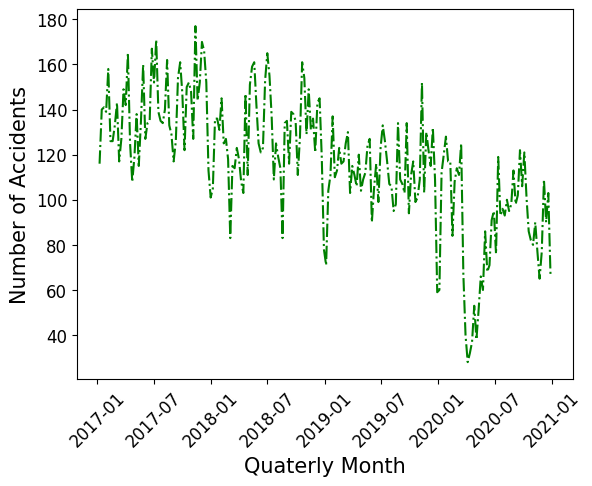

In [90]:
# Visualisation of the data
plt.plot(weekly_accidents.index, weekly_accidents['accident_count'], 'g-.')

# Adding labels and title
plt.xlabel('Quaterly Month', fontsize=15)
plt.ylabel('Number of Accidents', fontsize=15)

# Formatting the ticks on x and y axis
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Display the plot
plt.show()

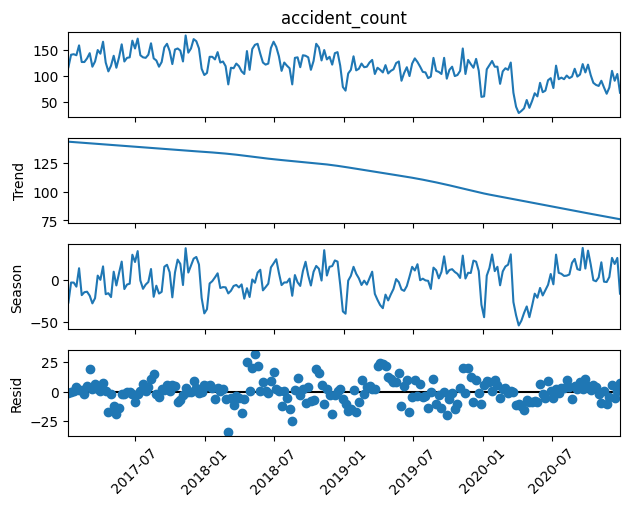

In [91]:
STL(weekly_accidents['accident_count']).fit().plot()
plt.xticks(rotation=45)
plt.show()

In [92]:
# Testing the differenced series for stationarity
ADF_test = adfuller(weekly_accidents)[:2]

print(f"ADF Statistic: {ADF_test[0]}; p-value {ADF_test[1]}")

ADF Statistic: -2.2623026929688526; p-value 0.18441439476655314


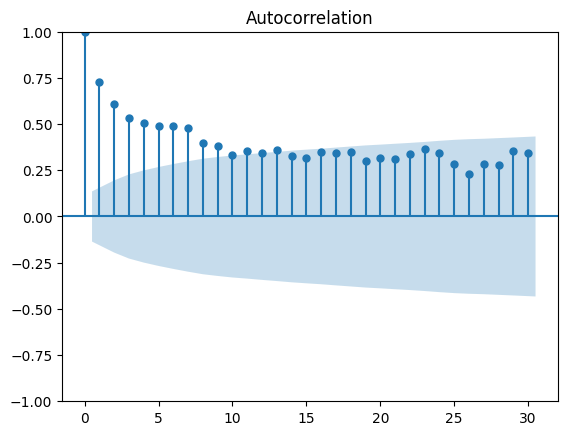

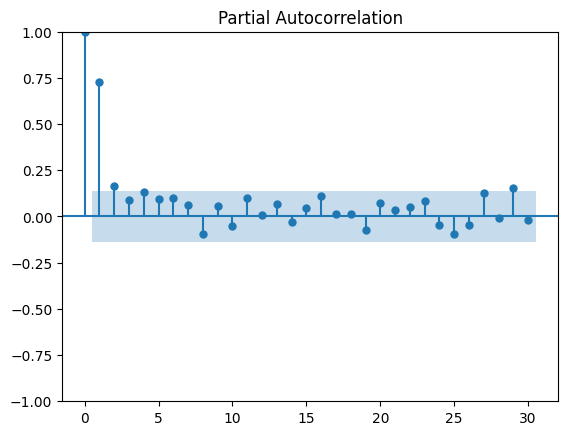

In [93]:
# Plot of ACF to understand the series 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(weekly_accidents, lags=30)
plot_pacf(weekly_accidents, lags=30)
plt.show()

In [94]:
diff_1 = weekly_accidents[['accident_count']].diff(1).dropna()
diff_1

,accident_count
date,
2017-01-15,24.0
2017-01-22,1.0
2017-01-29,-2.0
2017-02-05,19.0
2017-02-12,-32.0
...,...
2020-11-29,12.0
2020-12-06,32.0
2020-12-13,-19.0


In [95]:
adf_test = adfuller(diff_1)[:2]
print(f"ADF Statistic: {adf_test[0]}; p-value {adf_test[1]}")

ADF Statistic: -8.837952545714742; p-value 1.698872201721135e-14


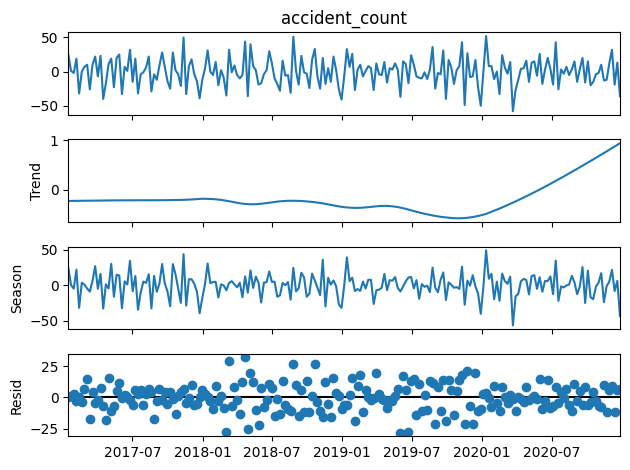

In [96]:
# Decomposition of the differenced series
STL(diff_1['accident_count']).fit().plot()
plt.show()

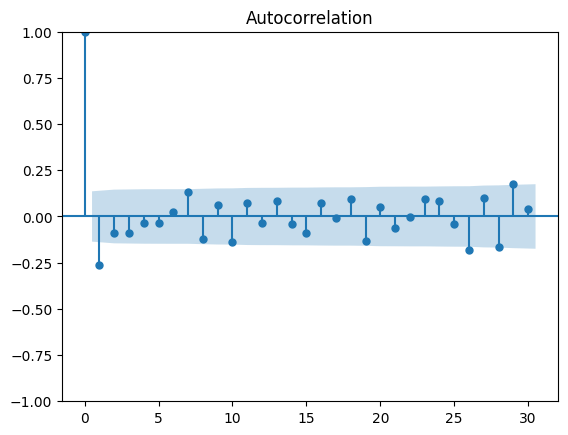

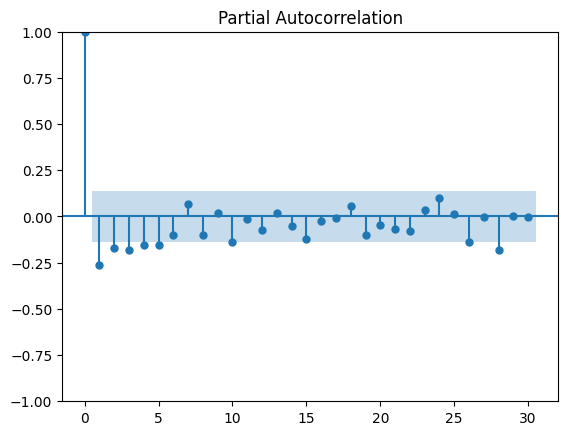

In [97]:
# Plot of ACF to understand the series 
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
plot_acf(diff_1, lags=30)
plot_pacf(diff_1, lags=30)
plt.show()

In [98]:
# Specifying a range of parameters to determine the order using AIC
from itertools import product
ps = np.arange(0,13,1) # Order of AR
qs = np.arange(0,13,1) # Order of MA
Ps = [0] # Seasonal order of AR
Qs = [0] # Seasonal order of MA
d = 1 # one-order differencing
D = 0 # Seasonal differencing
s = 52 # period
p_q_list = list(product(ps,qs,Ps,Qs))
p_q_list[:5]

[(np.int64(0), np.int64(0), 0, 0),
 (np.int64(0), np.int64(1), 0, 0),
 (np.int64(0), np.int64(2), 0, 0),
 (np.int64(0), np.int64(3), 0, 0),
 (np.int64(0), np.int64(4), 0, 0)]

In [99]:
from tqdm import tqdm  # To show a progress bar
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Function to compute AIC values for SARIMAX models
def compute_aic_values(train_s):
    """
    This function accepts a list of orders, training data, and model parameters,
    then returns the AIC values for each SARIMAX model.

    Parameters:
    - p_q_list: List of tuples containing orders (p, q, P, Q)
    - train_s: Training time series data
    - d: Non-seasonal differencing order
    - D: Seasonal differencing order
    - s: Seasonal periodicity

    Returns:
    - A DataFrame containing orders and their corresponding AIC values
    """
    aic_list = []  # Initialize an empty list to store AIC values

    for order in tqdm(p_q_list):  # Iterate over all orders in the list
        try:
            # Fit the SARIMAX model for the current order
            model = SARIMAX(
                endog=train_s,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False
            ).fit(disp=False)

            # Append the order and corresponding AIC value to the list
            aic_list.append([order, model.aic])
        except Exception as e:
            # Print detailed error message for debugging
            # print(f"Error fitting model for order {order}: {e}")
            continue

    # Convert the list of AIC values to a DataFrame
    aic_df = pd.DataFrame(aic_list, columns=['Order(p, q, Ps, Qs)', 'AIC'])

    # Sort the DataFrame by AIC values in ascending order and reset the index
    aic_df.sort_values(by='AIC', ascending=True, inplace=True)
    aic_df.reset_index(drop=True, inplace=True)

    return aic_df

In [100]:
train = weekly_accidents[['accident_count']][:-52] # 2017 to 2019
test = weekly_accidents[['accident_count']][-52:] # 2020

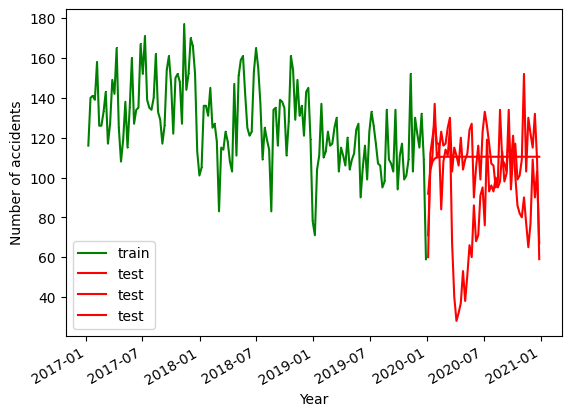

In [ ]:
fig,ax = plt.subplots()

ax.plot(train,'g-,', label='train')
ax.plot(test,'r-', label='test')
ax.set_xlabel('Year')
ax.set_ylabel('Number of accidents')
# Highlighting the range (example, adjust to your specific needs)
ax.axvspan(test.index[0], test.index[-1], alpha=0.2, color='yellow', label='Prediction Range')
fig.autofmt_xdate()
plt.legend()

In [102]:
aic_df = compute_aic_values(train)
aic_df

100%|██████████| 169/169 [01:55<00:00,  1.46it/s]


,"Order(p, q, Ps, Qs)",AIC
0,"(1, 1, 0, 0)",1338.357199
1,"(2, 2, 0, 0)",1339.671532
2,"(0, 2, 0, 0)",1339.752101
3,"(0, 3, 0, 0)",1340.013447
4,"(2, 1, 0, 0)",1340.204034
...,...,...
164,"(12, 10, 0, 0)",1362.151813
165,"(9, 4, 0, 0)",1363.094194
166,"(2, 0, 0, 0)",1364.285246
167,"(1, 0, 0, 0)",1369.581739


In [103]:
arima_model = SARIMAX(endog=train, order=(1, 1, 1)).fit()
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         accident_count   No. Observations:                  156
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -666.179
Date:                Thu, 10 Apr 2025   AIC                           1338.357
Time:                        13:16:35   BIC                           1347.487
Sample:                    01-08-2017   HQIC                          1342.066
                         - 12-29-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3616      0.083      4.359      0.000       0.199       0.524
ma.L1         -0.9416      0.035    -26.692      0.000      -1.011      -0.872
sigma2       313.6789     34.726      9.033      0.000     245.617     381.741
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.81
Prob(Q):                              0.94   Prob(JB):                         0.67
Heteroskedasticity (H):               0.92   Skew:                            -0.15
Prob(H) (two-sided):                  0.75   Kurtosis:                         3.19
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

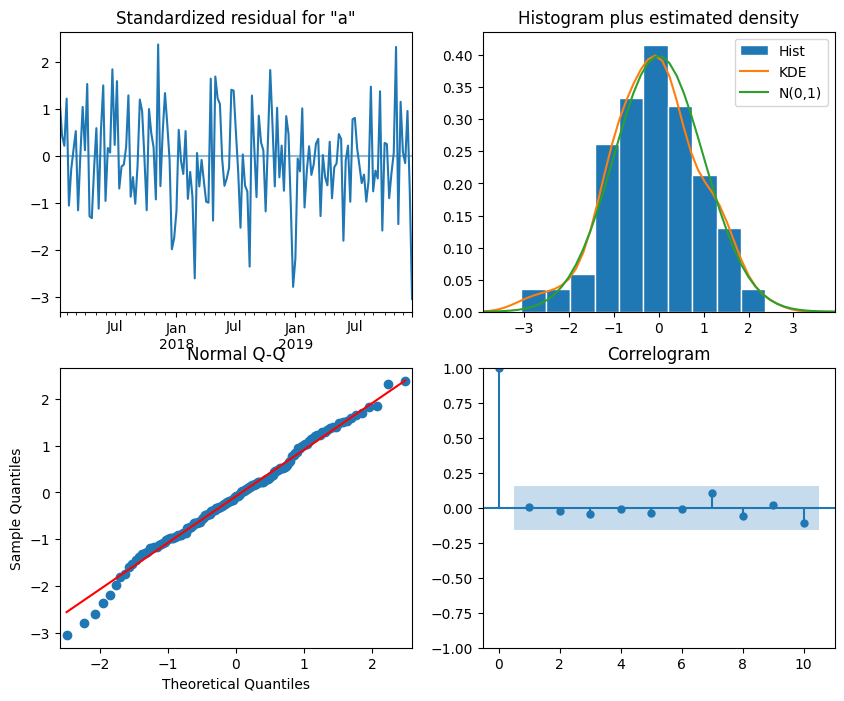

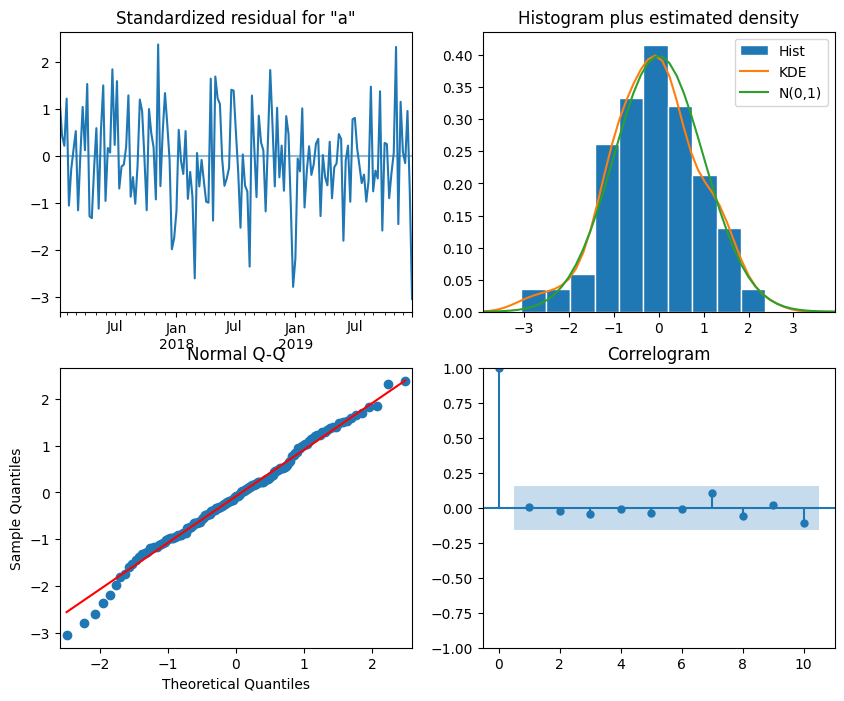

In [104]:
arima_model.plot_diagnostics(figsize=(10, 8))

In [105]:
# Evaluation using Ljung-Box test

from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(arima_model.resid) #returns test score for first 10 lags.

,lb_stat,lb_pvalue
1,0.436829,0.508657
2,0.438040,0.803306
3,0.539832,0.910057
4,0.755159,0.944357
5,1.419553,0.922163
6,1.446665,0.962958
7,2.747543,0.907334
8,2.888527,0.941157
9,2.940852,0.966594
10,4.047308,0.945188


In [106]:
# Get the length of the test set
len_test = len(test)

# Forecast using SARIMA model (adjust for differencing)
arima_pred = arima_model.get_forecast(len_test).predicted_mean.values
arima_pred_original = arima_pred + train['accident_count'].iloc[-1]  # Reverse differencing

# Forecast using Naive model (last values from training set)
naive_pred = train['accident_count'].iloc[-len_test:].values

# Add predictions to the test set
test['naive_pred'] = naive_pred
test['arima_pred'] = arima_pred_original

# Display the resulting DataFrame
print(test)

            accident_count  naive_pred  arima_pred
date                                              
2020-01-05              60          71  150.825813
2020-01-12             112         104  162.696996
2020-01-19             120         111  166.990110
2020-01-26             128         137  168.542679
2020-02-02             117         110  169.104153
2020-02-09             117         113  169.307205
2020-02-16              84         123  169.380638
2020-02-23             108         116  169.407194
2020-03-01             114         117  169.416798
2020-03-08             111         125  169.420271
2020-03-15             125         130  169.421527
2020-03-22              67         103  169.421981
2020-03-29              40         115  169.422145
2020-04-05              28         111  169.422205
2020-04-12              32         106  169.422226
2020-04-19              37         120  169.422234
2020-04-26              53         104  169.422237
2020-05-03              38     

In [107]:
# Forecasting the test set using both naive_model (using the last values) and arima
len_test = len(test)

arima_pred = arima_model.get_forecast(len_test).predicted_mean.values

naive_pred = train['accident_count'][len(train)-52:len(train)].values
test['naive_pred'] = naive_pred
test['arima_pred'] = arima_pred


test

,accident_count,naive_pred,arima_pred
date,,,
2020-01-05,60,71,91.825813
2020-01-12,112,104,103.696996
2020-01-19,120,111,107.990110
2020-01-26,128,137,109.542679
2020-02-02,117,110,110.104153
2020-02-09,117,113,110.307205
2020-02-16,84,123,110.380638
2020-02-23,108,116,110.407194
2020-03-01,114,117,110.416798


In [133]:
# Evaluation
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error

In [134]:
arima_mse = mean_squared_error(test['accident_count'],test['arima_pred'])
naive_mse = mean_squared_error(test['accident_count'],test['naive_pred'])

arima_rmse = np.sqrt(mean_squared_error(test['accident_count'], test['arima_pred']))
naive_rmse = np.sqrt(mean_squared_error(test['accident_count'], test['naive_pred']))

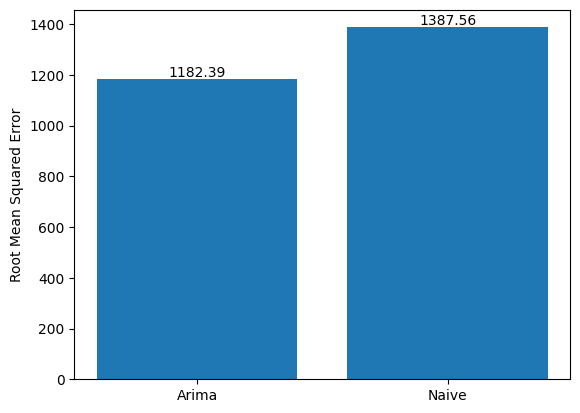

In [ ]:
# Plotting the results 

list_mse = [arima_mse,naive_mse]
models = ['Arima', 'Naive']
plt.bar(x=models,height=list_mse)
plt.ylabel('Mean Squared Error')

for i, value in enumerate(list_mse):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()

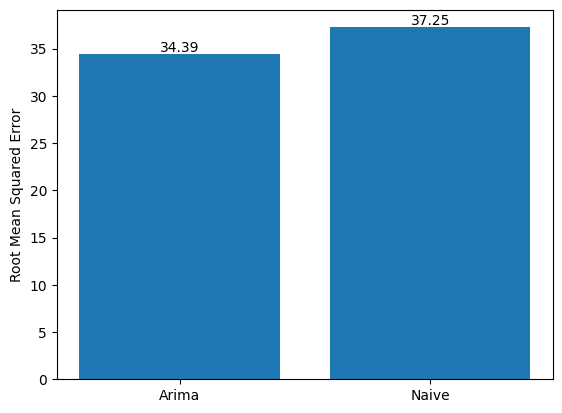

In [136]:
# Plotting the results 

list_rmse = [arima_rmse,naive_rmse]
models = ['Arima', 'Naive']
plt.bar(x=models,height=list_rmse)
plt.ylabel('Root Mean Squared Error')

for i, value in enumerate(list_rmse):
    plt.text(i, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()

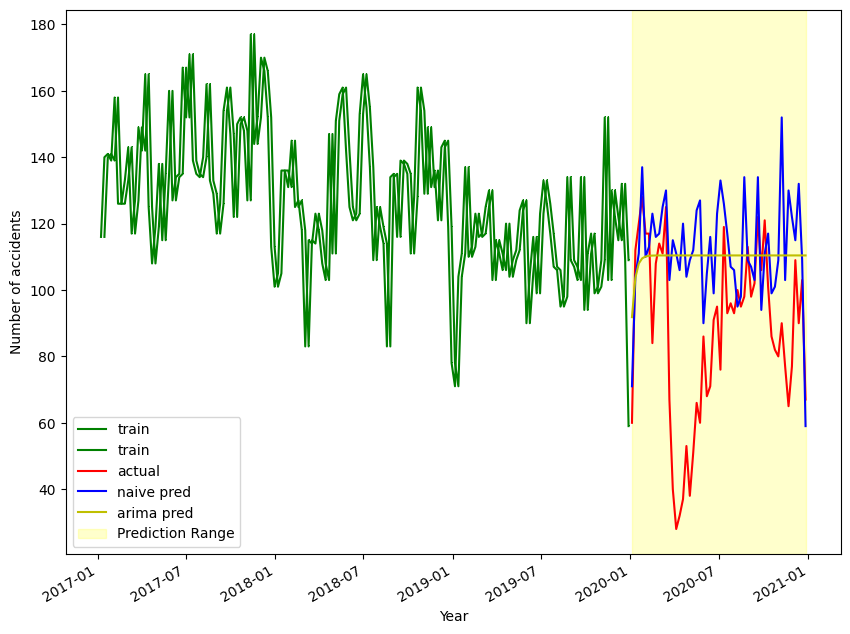

In [140]:
fig,ax = plt.subplots(figsize=(10,8))

ax.plot(train,'g-,', label='train')
ax.plot(test['accident_count'],'r-', label='actual')
ax.plot(test['naive_pred'], 'b-', label='naive pred')
ax.plot(test['arima_pred'], 'y-', label='arima pred')
ax.set_xlabel('Year')
ax.set_ylabel('Number of accidents')
# Highlighting the range (example, adjust to your specific needs)
ax.axvspan(test.index[0], test.index[-1], alpha=0.2, color='yellow', label='Prediction Range')
fig.autofmt_xdate()
plt.legend()

In [132]:
from xgboost import XGBRegressor

# Example: Assuming 'train_df' and 'test_df' are your dataframes
def create_lag_features(df, lag=1):
    df[f'lag_{lag}'] = df['accident_count'].shift(lag)
    return df.dropna()

# Add lag features for training
train_df = create_lag_features(train, lag=1)

# Add lag features for testing
test_df = create_lag_features(test[['accident_count']], lag=1)

# Split training data
X_train = train_df.drop(columns=['accident_count'])
y_train = train_df['accident_count']

X_test = test_df.drop(columns=['accident_count'])
y_test = test_df['accident_count']

# Initialize XGBoost regressor
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3)

# Fit the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_absolute_error(y_test, y_pred))
print(f'RMSE: {rmse}')

# Convert predictions into a DataFrame for visualization
predictions_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred
})
print(predictions_df)

RMSE: 5.094079691508799
            Actual   Predicted
date                          
2020-01-12     112  103.235718
2020-01-19     120  122.827599
2020-01-26     128  109.148865
2020-02-02     117  140.561157
2020-02-09     117  116.612038
2020-02-16      84  116.612038
2020-02-23     108  120.667397
2020-03-01     114  112.016350
2020-03-08     111  113.482353
2020-03-15     125  123.859703
2020-03-22      67  125.836517
2020-03-29      40  103.235718
2020-04-05      28  103.235718
2020-04-12      32  103.235718
2020-04-19      37  103.235718
2020-04-26      53  103.235718
2020-05-03      38  103.235718
2020-05-10      51  103.235718
2020-05-17      66  103.235718
2020-05-24      60  103.235718
2020-05-31      86  103.235718
2020-06-07      68  120.667397
2020-06-14      71  103.235718
2020-06-21      91  103.235718
2020-06-28      95  107.995193
2020-07-05      76  107.995193
2020-07-12     119  103.235718
2020-07-19      93  109.148865
2020-07-26      96  107.995193
2020-08-02     

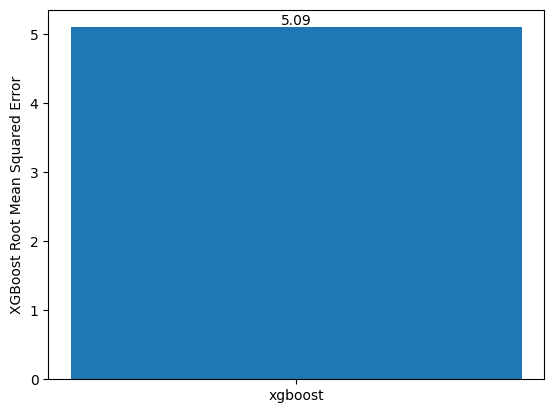

In [149]:
plt.bar(x='xgboost', height=rmse)
plt.text(0, rmse, f'{rmse:.2f}', ha='center', va='bottom')
plt.ylabel('XGBoost Root Mean Squared Error')
plt.show()


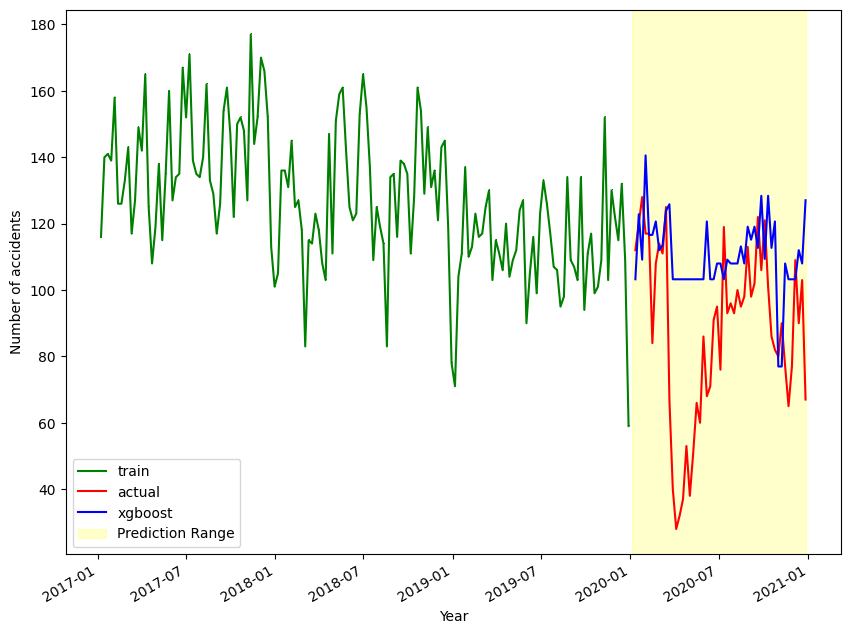

In [145]:
fig,ax = plt.subplots(figsize=(10,8))

ax.plot(train['accident_count'],'g-,', label='train')
ax.plot(predictions_df['Actual'], 'r-', label='actual')
ax.plot(predictions_df['Predicted'], 'b-', label='xgboost')
ax.set_xlabel('Year')
ax.set_ylabel('Number of accidents')
# Highlighting the range (example, adjust to your specific needs)
ax.axvspan(test.index[0], test.index[-1], alpha=0.2, color='yellow', label='Prediction Range')
fig.autofmt_xdate()
plt.legend()